<a href="https://colab.research.google.com/github/tablehan/deepLearningPractice/blob/main/LSTMforCCI30_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [128]:
import os
os.path.abspath('')

'/content'

In [129]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import time

In [133]:
# 從網路直接抓cci30過來測試建模
df=pd.read_csv("https://cci30.com/ajax/getIndexHistory.php",index_col=0).iloc[::-1,:]
print(df.shape)
df.head()

(2825, 5)


,Open,High,Low,Close,Volume
Date,,,,,
2015-01-01,101.3600,102.1530,98.8187,100.0000,0.0
2015-01-02,99.9137,101.8690,98.7938,100.2180,0.0
2015-01-03,100.2530,101.5400,88.7442,89.3769,0.0
2015-01-04,89.2479,91.1656,79.8710,82.2132,0.0
2015-01-05,82.3484,88.3190,81.5787,86.2289,0.0


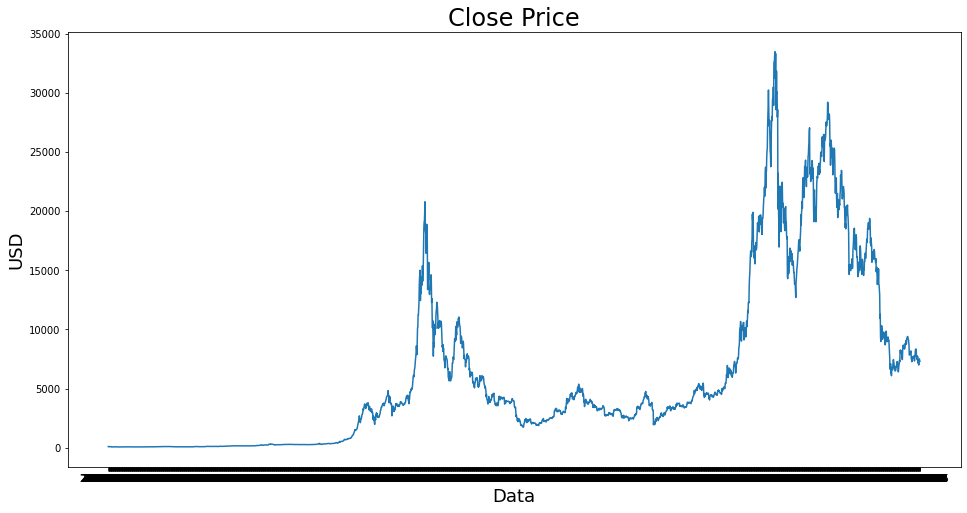

In [134]:
plt.figure(figsize=(16,8))
plt.title('Close Price', fontsize=24)
plt.plot(df['Close'])
plt.xlabel('Data', fontsize=18)
plt.ylabel('USD', fontsize=18)
plt.show()

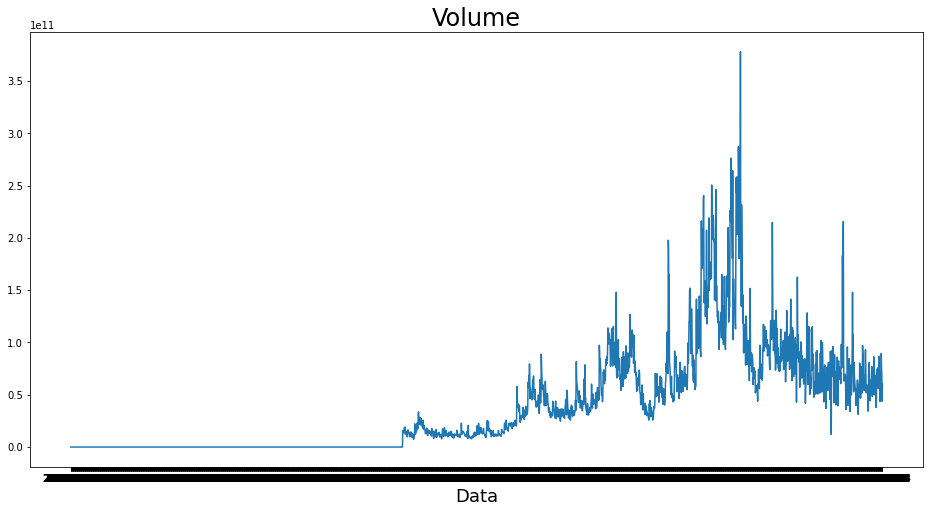

In [135]:
plt.figure(figsize=(16,8))
plt.title('Volume', fontsize=24)
plt.plot(df['Volume'])
plt.xlabel('Data', fontsize=18)
plt.show()

In [136]:
# exclude periods that valume=0
df=df[df['Volume']>0]
print(df.shape)
df

(1669, 5)


,Open,High,Low,Close,Volume
Date,,,,,
2018-03-01,10214.10,10885.90,10052.20,10656.90,1.556998e+10
2018-03-02,10659.00,10887.70,10284.20,10512.20,1.572008e+10
2018-03-03,10509.10,10844.10,10306.30,10516.90,1.424458e+10
2018-03-04,10511.30,10803.00,10198.60,10689.10,1.378689e+10
2018-03-05,10694.30,10941.70,10407.40,10523.00,1.565674e+10
...,...,...,...,...,...
2022-09-21,7175.97,7487.59,6859.38,6991.46,8.948092e+10
2022-09-22,6987.60,7488.88,6937.79,7436.58,7.369916e+10
2022-09-23,7436.16,7704.71,7154.14,7509.82,6.951557e+10


In [137]:
#Convert the dataframe to numpy array
dataset = df.values
# Get the number of rows to train the model on. we need this number to create our train and test sets
# math.ceil will round up the number
training_data_len = math.ceil(len(dataset) * .8) # We are using %80 of the data for training
training_data_len

1336

In [138]:
# Scale the data with MinMaxScaler
scaler_X = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler_X.fit_transform(dataset)
scaler_y = MinMaxScaler(feature_range=(0,1))
y_temp=dataset[:,3]
y_temp=y_temp.reshape(-1,1)
scaled_ydata = scaler_y.fit_transform(y_temp)
print(scaled_data)
print(scaled_ydata)

[[0.26718113 0.27445008 0.28023588 0.28102918 0.02205259]
 [0.28119915 0.27450425 0.28790962 0.27647164 0.0224575 ]
 [0.27647607 0.27319202 0.28864061 0.27661967 0.0184771 ]
 ...
 [0.17965311 0.17870599 0.18437824 0.18190715 0.16758007]
 [0.181974   0.17697392 0.19026784 0.17802048 0.0982427 ]
 [0.1780799  0.17394014 0.1865689  0.1755669  0.14246886]]
[[0.28102918]
 [0.27647164]
 [0.27661967]
 ...
 [0.18190715]
 [0.17802048]
 [0.1755669 ]]


In [139]:
# hyper param
timeStep=60
batch_size=1
epochs=20
d=0.2

In [140]:

# Creat the training dataset
train_data = scaled_data[0:training_data_len, :]

train_data[:,-2]
#Split the data into X_train and y_train data sets
X_train = np.array([train_data[i-timeStep:i,:] for i in range(60, len(train_data))])
y_train = np.array([train_data[i,-2] for i in range(60, len(train_data))])
print(f'X_train shape:{X_train.shape}',f'y_train_shape: {y_train.shape}')

X_train shape:(1276, 60, 5) y_train_shape: (1276,)


In [141]:
# Create the testing dataset
# Create a new array containing scaled values from index 1335
test_data = scaled_data[training_data_len - timeStep : , :]
X_test = np.array([test_data[i-timeStep: i,:] for i in range(timeStep,len(test_data))])
y_test = dataset[training_data_len : , 3]
print(f'X_test shape:{X_test.shape}',f'y_test_shape: {y_test.shape}')

X_test shape:(333, 60, 5) y_test_shape: (333,)


In [142]:
# Build LSTM model
tf.random.set_seed(42)

model_1 = Sequential()
model_1.add(LSTM(128, return_sequences=True, input_shape=(timeStep, X_train.shape[-1])))
model_1.add(Dropout(d))
model_1.add(LSTM(128, return_sequences=False))
model_1.add(Dropout(d))
model_1.add(Dense(32))
model_1.add(Dense(1))

In [143]:
# Compile the model
model_1.compile(optimizer='adam', loss='mse')
print(model_1.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 60, 128)           68608     
                                                                 
 dropout_8 (Dropout)         (None, 60, 128)           0         
                                                                 
 lstm_11 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 32)                4128      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 204,353
Trainable params: 204,353
Non-tr

In [144]:
# Train the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
history = model_1.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/20
1276/1276 [==============================] - 14s 9ms/step - loss: 0.0046
Epoch 2/20
1276/1276 [==============================] - 12s 9ms/step - loss: 0.0031
Epoch 3/20
1276/1276 [==============================] - 12s 9ms/step - loss: 0.0023
Epoch 4/20
1276/1276 [==============================] - 12s 9ms/step - loss: 0.0027
Epoch 5/20
1276/1276 [==============================] - 12s 9ms/step - loss: 0.0020
Epoch 6/20
1276/1276 [==============================] - 12s 9ms/step - loss: 0.0019
Epoch 7/20
1276/1276 [==============================] - 12s 9ms/step - loss: 0.0024
Epoch 8/20
1276/1276 [==============================] - 12s 9ms/step - loss: 0.0018
Epoch 9/20
1276/1276 [==============================] - 12s 9ms/step - loss: 0.0019
Epoch 10/20
1276/1276 [==============================] - 12s 9ms/step - loss: 0.0017
Epoch 11/20
1276/1276 [==============================] - 12s 9ms/step - loss: 0.0013
Epoch 12/20
1276/1276 [==============================] - 12s 9ms/step - lo

In [145]:
# Get the model_1 predicted price values 
predictions_1 = model_1.predict(X_test)
predictions_1 = scaler_y.inverse_transform(predictions_1)
predictions_1[:5,:]

array([[23716.172],
       [24194.158],
       [25202.777],
       [24848.342],
       [24654.434]], dtype=float32)

In [146]:
# Get the root mean squared error (RMSE) for model_1
rmse = np.sqrt(np.mean(predictions_1 - y_test)**2)
rmse

268.72061866554014

Text(0.5, 0, 'epochs')

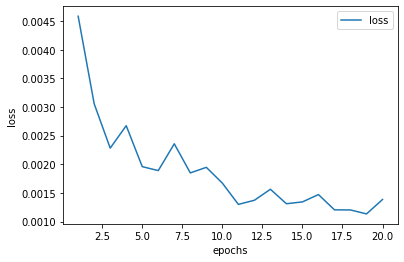

In [147]:
# Let's plot the history of model_1 and see what's going on
historyForPlot = pd.DataFrame(history.history)
historyForPlot.index += 1 # we plus 1 to the number of indexing so our epochs Plot picture will be counting from 1 not 0.
historyForPlot.plot()
plt.ylabel("loss")
plt.xlabel("epochs")

In [96]:
# reference
# https://github.com/Ali619/Bitcoin-Price-Prediction-LSTM/blob/master/Bitcoin_Price_Prediction.ipyn

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


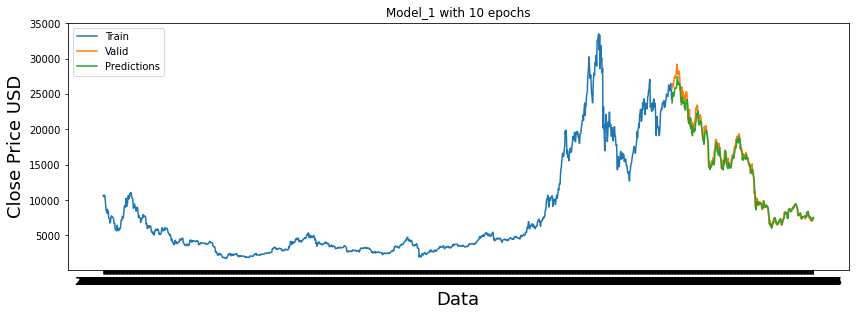

In [157]:
# Plot the data
train = df.iloc[:training_data_len]
# data for model_1
valid_1 = df.iloc[training_data_len:,:]
valid_1['Predictions'] = predictions_1

plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.title('Model_1 with 10 epochs')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.plot(train["Close"])
plt.plot(valid_1[["Close","Predictions"]])
plt.legend(['Train', 'Valid', 'Predictions'], loc='upper left')

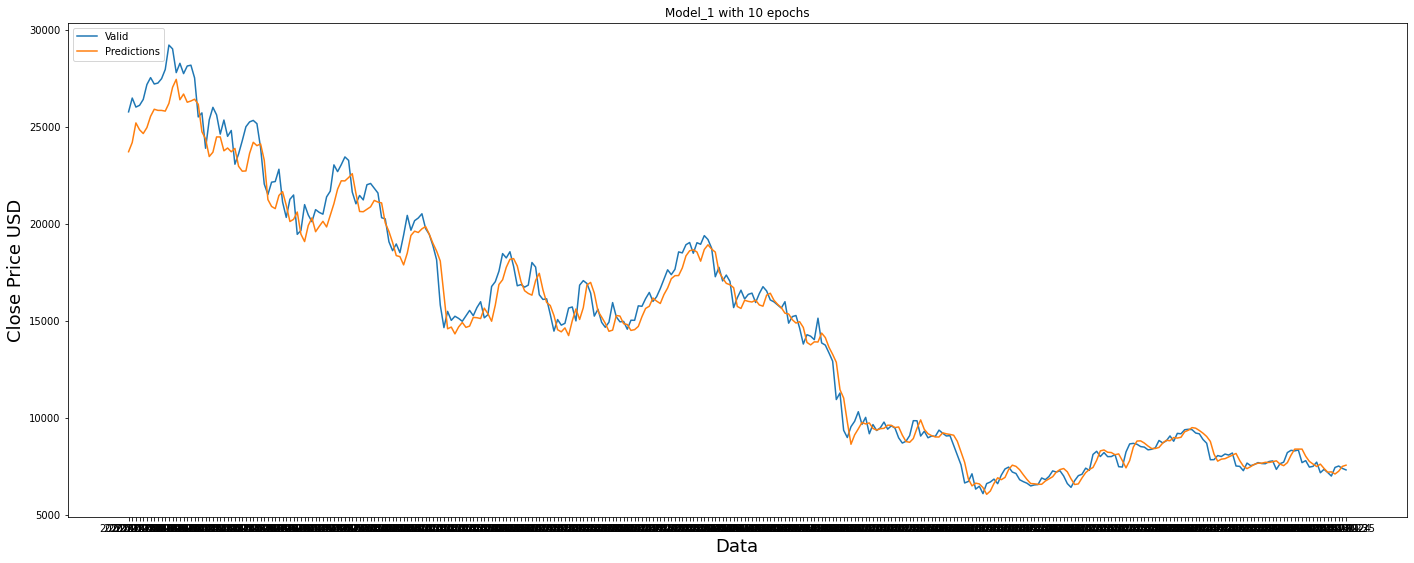

In [159]:
plt.figure(figsize=(24, 20))
plt.subplot(2, 1, 1)
plt.title('Model_1 with 10 epochs')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.plot(valid_1[["Close","Predictions"]])
plt.legend(['Valid', 'Predictions'], loc='upper left')